Author:
        
        PARK, JunHo, junho@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

# Proving CCNet as a Causal Model: Two Evidences for Conditional Independence and Causal Generation

## Overview of CCNet

CCNet (Cooperative Causal Network) introduces a framework for understanding causal dynamics in observed data. It decouples direct causes of observations (X) from target outcomes (Y) by leveraging neural networks to identify explanatory factors (E) that are conditionally independent of Y, given X.

CCNet ensures that E remains independent of Y, given X, while also generating new observations (X) that preserve the statistical properties of the original dataset. By manipulating Y through the causal model, CCNet validates that the generated data follows the same underlying causal relationships as the original data, thereby reinforcing causal generation over mere causal inference, which is limited in the current study.

## Methodology for Causal Learning

CCNet employs three interconnected neural network models—Explainer, Reasoner, and Producer—to establish the conditional independence of E from Y, given X, and to generate realistic data.

## Experiment Description

### Objective

Validate CCNet's effectiveness in:
1. **Conditional Independence**: Demonstrating that E is conditionally independent of Y, given X.
2. **Causal Generation**: Showing that altering Y can generate new X while maintaining the distribution of the original dataset.

### Dataset

The Airline Customer Satisfaction dataset includes:
- **`satisfaction`**: Binary satisfaction status (satisfied or not satisfied).
- **`Gender`**: Categorical gender data (e.g., male, female, etc.).

### Methodology

#### Dataset Preparation

- **CausalModelDataset**: Configures features X in the dataset with either `satisfaction` or `Gender` as the target.
- **EncodingDataset**: Generates explanatory encodings (E) from the data for prediction modeling.

#### Training Process

##### Conditional Independence Proof

1. **Causal Model Training**: Train the causal model iteratively to discover E and understand the relationships between X and Y.
2. **Prediction Modeling**:
   - **Selected Target Classifier**: Train on encodings (E) for the selected target (`satisfaction` or `Gender`).
   - **Non-Selected Target Classifier**: Train on encodings (E) for the non-selected target (`Gender` if `satisfaction` is selected, and vice versa).
   - **Feature Switching**: Alternate between selected and non-selected targets to demonstrate that E predicts the non-selected Y but not the selected Y, proving conditional independence regardless of the specific data domain.

##### Data Generation Proof

1. **Train CCNet**: Train CCNet on the Airline Customer Satisfaction training set.

###### First Part

1. **Train Classifier**: Train a classifier on the original dataset.
2. **Recreate Test Set**: Use the causal model to generate a new test set by randomly altering Y.
3. **Evaluation**: Test the classifier on the recreated test set and compare the results with the original test set to confirm that the real data distribution is preserved.

###### Second Part

1. **Data Generation**: Generate new observations (X) by randomly altering Y (e.g., `satisfaction`), ensuring that the generated data maintains the appearance and frequency distribution of the original dataset.
2. **Classifier Training as Validators**:
   - **Original Data Classifier**: Train a classifier on the original dataset.
   - **Generated Data Classifier**: Train a classifier on the data generated with randomly sampled labels.
3. **Performance Evaluation**:
   - **Prediction Alignment**: Evaluate how well the classifier trained on the original data predicts the labels of the generated data.
   - **Comparative Analysis**: Compare the performance metrics of classifiers trained on the original data and the generated data to validate their alignment and similarity.


In [1]:
import sys
import pandas as pd 
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

# https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data

df_train = pd.read_csv(path_append + '../data/Airline Customer Satisfaction/train.csv')
df_test = pd.read_csv(path_append + '../data/Airline Customer Satisfaction/test.csv')
df_train.head()
df_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [3]:
# Check labels count
df_train[['satisfaction']].value_counts()

satisfaction           
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64

In [4]:
# Check labels count
df_train[['Gender']].value_counts()

Gender
Female    52727
Male      51177
Name: count, dtype: int64

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from tools.preprocessing.data_frame import auto_preprocess_dataframe

# take a part of df
# Assuming df_train and df_test are your initial dataframes
df_train_length = len(df_train)
df_test_length = len(df_test)

# Concatenate the dataframes
df = pd.concat([df_train, df_test], axis=0)

# Define the columns to be processed
target_columns = ['satisfaction', 'Gender']
drop_columns = ['Unnamed: 0', 'id']

# Process the combined dataframe
df, description = auto_preprocess_dataframe(df, target_columns, drop_columns=drop_columns)

# Split the dataframe back into training and test sets
df_train = df.iloc[:df_train_length].reset_index(drop=True)  # Use reset_index to maintain the original index structure
df_test = df.iloc[df_train_length:].reset_index(drop=True)   # Use reset_index to maintain the original index structure

# Retrieve the number of features and classes after preprocessing
num_features = description['num_features']
num_classes = description['num_classes']

# Define the test size (if needed)
TEST_SIZE = 0.3

# Output the number of features and classes
print(f"Number of features after scaling: {num_features}")
print(f"Number of classes after scaling: {num_classes}")


Dropped columns: Unnamed: 0, id
Number of missing values in each column:
Arrival Delay in Minutes    393
dtype: int64
Number of rows dropped due to missing values: 393

Column 'Class' has 3 unique values.
Column 'Customer Type' has 2 unique values.
Column 'Type of Travel' has 2 unique values.
Column 'satisfaction' has 2 unique values.
Column 'Gender' has 2 unique values.


c:\Users\ccnets-team\Projects\causal-learning\examples\..\tools\preprocessing\encode.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[PROCESSED_PREFIX + col] = le.fit_transform(df[col])
c:\Users\ccnets-team\Projects\causal-learning\examples\..\tools\preprocessing\encode.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[col], inplace=True)
c:\Users\ccnets-team\Projects\causal-learning\examples\..\tools\preprocessing\encode.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Min,Max,Mean,Std,Null Count,Scaled,Encoded
Age,-2.577884,3.622629,-2.611987e-16,1.201755,0,Minmax,None
Flight Distance,-0.611278,3.112030,2.603088e-01,0.750046,0,Robust,None
Inflight wifi service,-2.728544,2.271456,1.876680e-16,1.329235,0,None,None
Departure/Arrival time convenient,-3.057349,1.942651,2.411698e-17,1.526787,0,None,None
Ease of Online booking,-2.756786,2.243214,-1.230268e-16,1.401662,0,None,None
Gate location,-2.976909,2.023091,-2.582355e-16,1.278506,0,None,None
Food and drink,-3.204685,1.795315,6.101952e-17,1.329905,0,None,None
Online boarding,-3.252720,1.747280,-2.030326e-16,1.350651,0,None,None
Seat comfort,-3.441589,1.558411,2.934644e-16,1.319168,0,None,None
Inflight entertainment,-3.358067,1.641933,2.368348e-16,1.334149,0,None,None


Number of features after scaling: 23
Number of classes after scaling: 4


In [6]:
# Defining the labeled and unlabeled dataset classes
class LabeledDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.detach().cpu() if isinstance(x, torch.Tensor) else x
        self.y = y.detach().cpu() if isinstance(y, torch.Tensor) else y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        vals = self.x[index] if isinstance(self.x, torch.Tensor) else torch.tensor(self.x[index], dtype=torch.float32)
        label = self.y[index] if isinstance(self.y, torch.Tensor) else torch.tensor(self.y[index], dtype=torch.float32)
        return vals, label

In [7]:
# Set a fixed random seed for reproducibility of experiments
from nn.utils.init import set_random_seed
set_random_seed(0)

# Importing configuration setups for ML parameters and data
import torch
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from trainer_hub import TrainerHub as CasualTrainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def initialize_causal_trainer():  
    num_classes = 1

    # Initializing ML parameters without a core model and setting the encoder model to 'tabnet' with specific configurations
    ml_params = MLParameters(ccnet_network='tabnet', encoder_network='none')

    # Configuration for the data handling, defining dataset specifics and the task type
    data_config = DataConfig(dataset_name='Airline Customer Satisfaction', task_type='binary_classification', obs_shape=[num_features],
                            label_size=num_classes, explain_size=128)

    # Setting training parameters and device configuration
    ml_params.training.num_epoch = 1
    ml_params.model.ccnet_config.num_layers = 3
    ml_params.algorithm.error_function = 'mse'

    # Create a TrainerHub instance to manage training and data processing
    causal_trainer = CasualTrainer(ml_params, data_config, device, use_print=True, use_wandb=False)
    
    return causal_trainer

In [8]:

from nn.tabnet import TabNet 
from tools.setting.ml_params import ModelConfig

class PredictionModel(torch.nn.Module):
    def __init__(self, input_size, output_size, num_layers=3, hidden_size=256):
        super(PredictionModel, self).__init__()
        
        model_config = ModelConfig('tabnet')
        model_config.num_layers = num_layers
        model_config.d_model = hidden_size
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_size))
        layers.append(torch.nn.ReLU())
        
        ## Add TabNet layers
        layers.append(TabNet(model_config))
        layers.append(torch.nn.ReLU())

        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))
        
        # Register all layers
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return torch.sigmoid(x)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

def initialize_plot():
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.set_title('Metrics over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 Score')
    
    return fig, ax
def display_plot(fig):
    clear_output(wait=True)  # Clear the previous output
    display(fig)  # Display the updated figure
    plt.pause(0.1)  # Allow the plot to update

def plot_metric(ax, epochs, selected_results, none_selected_results):
    ax.cla()  # Clear the previous plot without resetting the axis
    
    # Plot selected results
    ax.plot(epochs, selected_results['f1_score'], label='Selected Attributes (F1 Score)', linestyle='-', marker='o')
    
    # Plot non-selected results
    ax.plot(epochs, none_selected_results['f1_score'], label='Non-selected Attributes (F1 Score)', linestyle='--', marker='x')
    
    # Set labels and title
    ax.set_title('Metrics over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 Score')
    ax.legend()
    display_plot(ax.figure)
    

In [10]:

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, r2_score

# Testing function for the model
def _test_prediction_model(model, dataset, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            
            preds = torch.sigmoid(outputs).round()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return accuracy, f1

# Function to test the prediction models and update plots
def test_prediction_models(epoch, ax, selected_classifier, none_selected_classifier, testset_selected, testset_none_selected, 
                            selected_results, none_selected_results, device):
    print(f"Testing causal classifier on selected attributes at epoch {epoch}...")
    selected_metrics = _test_prediction_model(selected_classifier, testset_selected, device)
    selected_results['f1_score'].append(selected_metrics[1])

    print(f"Testing classifier on non-selected attributes at epoch {epoch}...")
    none_selected_metrics = _test_prediction_model(none_selected_classifier, testset_none_selected, device)
    none_selected_results['f1_score'].append(none_selected_metrics[1])
    
    # Update plots
    epochs = range(1, len(selected_results['f1_score']) + 1)
    plot_metric(ax, epochs, selected_results, none_selected_results)



In [11]:
import torch
from torch.utils.data import DataLoader

# Function to train classifier
DECAY_RATE = 0.01
ITERATION_100K = 100000
gamma = pow(DECAY_RATE, 1 / ITERATION_100K)

def train_prediction_model(model, trainset, num_epochs=5, gamma=gamma, device='cuda'):
    model.train()
    train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
    len_loader = len(train_loader)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    for epoch in range(num_epochs):
        sum_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(data)

            # Using binary cross-entropy loss for binary classification
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            sum_loss += loss.item()
        
        avg_loss = sum_loss / len_loader
        print(f"Epoch: {epoch + 1}, Loss: {avg_loss:.4f}")

    print(f"Final Learning rate: {optimizer.param_groups[0]['lr']:.8f}")


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

def train_causal_and_prediction_models(selected_target: str, non_selected_target: str, num_epoch = 10):
    
    train_x_selected = torch.Tensor(df_train.drop(columns=[selected_target, non_selected_target]).values[:])
    train_y_selected = torch.Tensor(df_train[selected_target].values[:]).unsqueeze(-1)
    
    test_x_selected = torch.Tensor(df_test.drop(columns=[selected_target, non_selected_target]).values[:])
    test_y_selected = torch.Tensor(df_test[selected_target].values[:]).unsqueeze(-1)
    
    train_x_non_selected = torch.Tensor(df_train.drop(columns=[selected_target, non_selected_target]).values[:])
    train_y_non_selected = torch.Tensor(df_train[non_selected_target].values[:]).unsqueeze(-1)
    
    test_x_non_selected = torch.Tensor(df_test.drop(columns=[selected_target, non_selected_target]).values[:])
    test_y_non_selected = torch.Tensor(df_test[non_selected_target].values[:]).unsqueeze(-1)
    
    # Initialize the plot and line objects only once
    fig, ax = initialize_plot()

    # Create LabeledDataset instances
    causal_model_dataset = LabeledDataset(train_x_selected, train_y_selected)
    # Initialize causal trainer
    causal_trainer = initialize_causal_trainer()

    # Create dictionaries to store results
    selected_results_dict = {'f1_score': []}
    non_selected_results_dict = {'f1_score': []}
    
    for epoch in range(num_epoch):
        if epoch > 0:
            print(f"Training causal model at epoch {epoch}...")
            causal_trainer.train(causal_model_dataset)
        causal_model = causal_trainer.ccnet

        selected_prediction_model = PredictionModel(causal_model.explain_size, 1).to(device)
        non_selected_prediction_model = PredictionModel(causal_model.explain_size, 1).to(device)

        # Train and evaluate classifiers on the explanation datasets
        print("Training causal classifier on selected attributes...")
        train_explain_selected = causal_model.explain(train_x_selected.to(device))
        trainset_explain_selected = LabeledDataset(train_explain_selected, train_y_selected)
        test_explain_selected = causal_model.explain(test_x_selected.to(device))
        testset_explain_selected = LabeledDataset(test_explain_selected, test_y_selected)
        train_prediction_model(selected_prediction_model, trainset_explain_selected, device = device)

        print("Training classifier on non-selected attributes...")
        train_explain_non_selected = causal_model.explain(train_x_non_selected.to(device))
        trainset_explain_non_selected = LabeledDataset(train_explain_non_selected, train_y_non_selected)
        test_explain_non_selected = causal_model.explain(test_x_non_selected.to(device))
        testset_explain_non_selected = LabeledDataset(test_explain_non_selected, test_y_non_selected)
        train_prediction_model(non_selected_prediction_model, trainset_explain_non_selected, device = device)
        
        # Test classifiers
        test_prediction_models(epoch, ax, 
                               selected_prediction_model, non_selected_prediction_model,
                               testset_explain_selected, testset_explain_non_selected,
                               selected_results_dict, non_selected_results_dict, 
                               device)

        print("selected_results_dict", selected_results_dict)
        print("non_selected_results_dict", non_selected_results_dict)

    plt.ioff()  # Turn off interactive mode
    plt.show()
    
    return causal_trainer


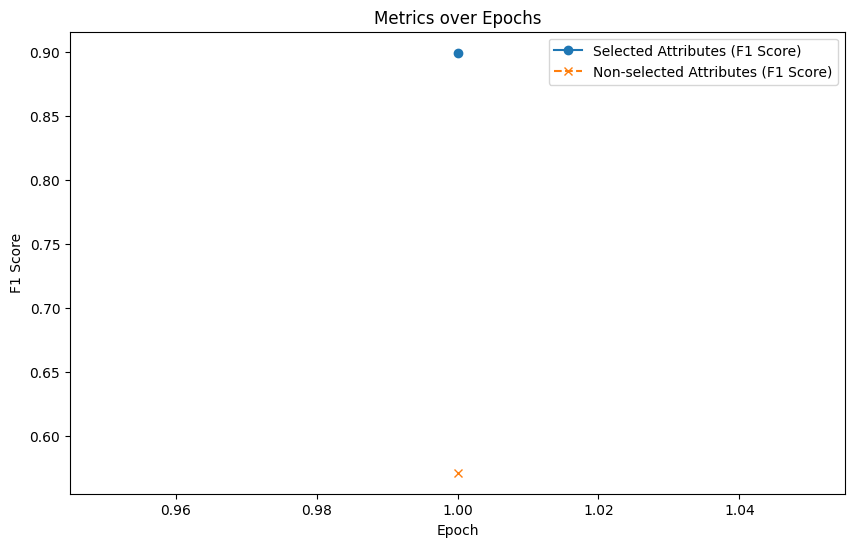

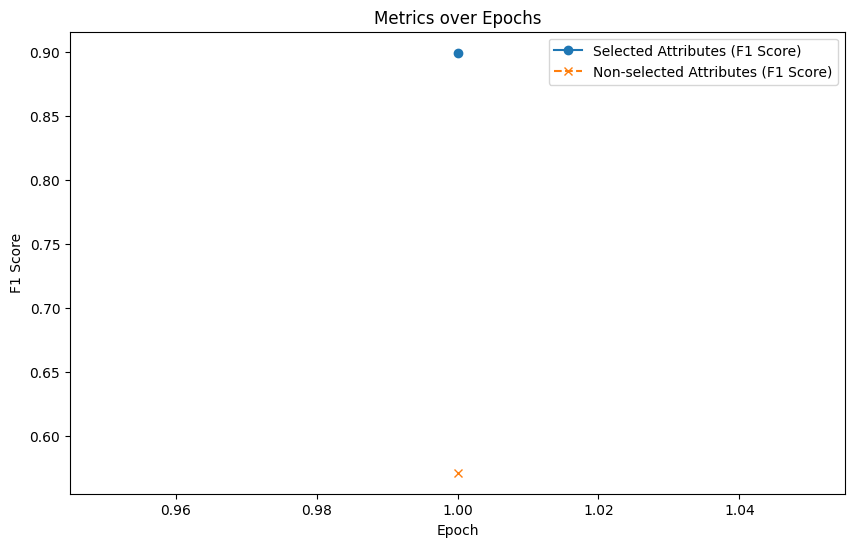

selected_results_dict {'f1_score': [0.8994801693105152]}
non_selected_results_dict {'f1_score': [0.5710919611884546]}
Training causal model at epoch 1...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations:   0%|          | 0/1623 [00:00<?, ?it/s]

[0/1][100/1623][Time 8.98]
Unified LR across all optimizers: 0.0001993957766378747
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.1780	Gen: 0.5604	Rec: 0.5573	E: 0.0841	R: 0.0705	P: 1.1526
[0/1][200/1623][Time 8.90]
Unified LR across all optimizers: 0.00019879933411171295
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.1122	Gen: 0.3966	Rec: 0.3957	E: 0.0331	R: 0.0340	P: 0.5887
[0/1][300/1623][Time 8.87]
Unified LR across all optimizers: 0.00019820467569398644
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0981	Gen: 0.3484	Rec: 0.3471	E: 0.0248	R: 0.0227	P: 0.4573
[0/1][400/1623][Time 9.51]
Unified LR across all optimizers: 0.00019761179604798148
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0880	Gen: 0.3251	Rec: 0.3231	E: 0.0207	R: 0.0189	P: 0.3998
[0/1][500/1623][Time 9.58]
Unified LR across all optimizers: 0.0001970206898529479
------

In [13]:
satisfaction_causal_trainer = train_causal_and_prediction_models(selected_target = 'satisfaction', non_selected_target = 'Gender')

In [ ]:
Gender_causal_trainer = train_causal_and_prediction_models(non_selected_target = 'Gender', selected_target = 'satisfaction')

# Airline Customer Satisfaction: Causal Generation with CCNet

## Introduction

This tutorial explores the use of a Cooperative Network (CCNet) to address challenges associated with imbalanced datasets in the domain of airline customer satisfaction. By leveraging the power of data generation, we aim to enhance the diversity and volume of training data, thereby improving the robustness and accuracy of models designed to identify and predict customer satisfaction.

## Tutorial Goals

The objectives of this tutorial are designed to guide you through the process of enhancing data quality and model performance:

### Dataset Recreation with CCNet
- **Understand Data Augmentation**: Learn how encoding techniques can be used to generate synthetic data instances that closely mimic the characteristics of real-world satisfied and dissatisfied customers.
- **Impact on Model Training**: Assess how augmenting the dataset influences the training process and subsequently, the model's ability to generalize from training to real-world scenarios.

### Model Training and Evaluation
- **Dual Model Training**: Train two distinct models to directly compare performance metrics:
  - A model trained on the **original dataset**.
  - A model trained on the **CCNet-augmented dataset**.
- **Performance Metrics**: Use the F1 score, a critical measure for models operating on imbalanced datasets, to evaluate and compare the effectiveness of these models.

### Testing and Validation
- **Independent Model Testing**: Conduct a thorough evaluation of both models using a standalone test set that was not involved in the training phase.
- **Objective Analysis**: Critically analyze the outcomes to validate whether data augmentation through CCNet offers a tangible benefit in predicting customer satisfaction.

## Conclusion

By the end of this tutorial, participants will not only grasp the theoretical underpinnings of using synthetic data to combat data imbalance but also gain hands-on experience in applying these concepts through CCNet to potentially enhance model performance in predicting customer satisfaction in the airline industry.


In [ ]:
train_x = torch.Tensor(df_train.drop(columns=['satisfaction', 'Gender']).values[:])
train_y = torch.Tensor(df_train['satisfaction'].values[:]).unsqueeze(-1)

test_x = torch.Tensor(df_test.drop(columns=['satisfaction', 'Gender']).values[:])
test_y = torch.Tensor(df_test['satisfaction'].values[:]).unsqueeze(-1)
# Labeled datasets for supervised learning tasks
trainset = LabeledDataset(train_x, train_y)  # Corrected to include training data
testset = LabeledDataset(test_x, test_y)     # Test set with proper labels

In [ ]:
import torch
from tools.loader import collate_fn

len_trainset = len(trainset)
causal_model = satisfaction_causal_trainer.ccnet
# Initialize the recreated dataset container

# Generate synthetic data through the model to augment the training dataset
# Generate a large amount of synthetic data
train_explain = causal_model.explain(train_x.to(device))
test_explain = causal_model.explain(test_x.to(device))

recreated_train_data, recreated_train_label = causal_model.generate(train_explain)
recreated_test_data, recreated_test_label = causal_model.generate(test_explain)

recreated_train_data = recreated_train_data.squeeze(1).detach().cpu()
recreated_train_label = recreated_train_label.detach().cpu().argmax(dim=-1).unsqueeze(-1)

recreated_test_data = recreated_test_data.squeeze(1).detach().cpu()
recreated_test_label = recreated_test_label.detach().cpu().argmax(dim=-1).unsqueeze(-1)

print("recreated_train_data shape", recreated_train_data.shape)
print("recreated_train_label shape", recreated_train_label.shape)

print("recreated_test_data shape", recreated_test_data.shape)
print("recreated_test_label shape", recreated_test_label.shape)

# Assuming recreated_dataset is a PyTorch tensor already available in your context
recreated_trainset = LabeledDataset(recreated_train_data, recreated_train_label)
recreated_testset = LabeledDataset(recreated_test_data, recreated_test_label)

In [ ]:
def train_supervised_model(model, dataset, num_epoch=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Ensure reproducibility by resetting the random seed
    # Create DataLoader for batch processing
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    # Training loop
    for epoch in range(num_epoch):  # Train for 2 epochs as an example
        for i, (data, label) in enumerate(trainloader):
            data = data.to(device).clone().detach()
            label = label.to(device).float()
            # Perform forward pass
            output = model(data)
            # Compute loss
            loss = torch.nn.functional.binary_cross_entropy(output, label)
            # Backward pass to compute gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()


In [ ]:
# Initialize and train a model on the recreated dataset
model_trained_on_recreated = PredictionModel(input_size=num_features, output_size=1).to(device)
train_supervised_model(model_trained_on_recreated, recreated_trainset)

# Initialize and train a model on the original dataset
model_trained_on_original = PredictionModel(input_size=num_features, output_size=1).to(device)
train_supervised_model(model_trained_on_original, trainset)

In [ ]:
from sklearn.metrics import f1_score

def get_f1_score(model, testset, batch_size=256):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    # DataLoader for testing
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # No gradient computation needed during inference
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            # Process output for binary classification
            predicted = (output.squeeze() > 0.5).long()
            y_true.extend(label.squeeze().long().cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute and return the F1 score
    score = f1_score(y_true, y_pred, average='binary')
    return score

# Calculate F1 scores for both models
f1_score_original_model_on_testset = get_f1_score(model_trained_on_original, testset)
f1_score_original_model_on_recreated_testset = get_f1_score(model_trained_on_original, recreated_testset)
f1_score_recreated_model_on_testset = get_f1_score(model_trained_on_recreated, testset)

# Output the results
print("F1 score of the model trained on the original data evaluated on the test set: ", f1_score_original_model_on_testset)
print("F1 score of the model trained on the original data evaluated on the recreated test set: ", f1_score_original_model_on_recreated_testset)
print("F1 score of the model trained on the recreated data evaluated on the test set: ", f1_score_recreated_model_on_testset)
